In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from matplotlib import cm
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence

In [2]:
%matplotlib inline

In [3]:
# from stytra
def calcium_kernel(tau):
    return lambda x: np.exp(-x/(tau/np.log(2)))


def convolve_regressors(regressor, kernel):
    """ Convolves the regressor with a kernel function
    :param regressor: the regressor, or regressor matrix
    :param kernel:
    :return: the convolved kernel
    """
    return np.convolve(regressor, kernel)[0:len(regressor)]


def matplot2plotly_cmap(cmap_type, nsamp=200):
    x = (np.linspace(0, 1, nsamp))
    color_mat = (cm.get_cmap(cmap_type)(x)*255).astype(np.uint8)[:,:3]
    return [[v, "rgb{}".format(tuple(c))] for v, c in zip(x, color_mat)]


def nandot(X, Y):
    return np.nansum(X*Y)


def pearson_coef_pixel(pixel, regressor):
    X = pixel_traces[pixel]
    Y = regressor
    # if regressor is shorter, reduce the size of the pixel trace
    if X.shape != Y.shape:
        Y_bis = np.zeros(X.shape)
        Y_bis[0:len(Y)] = Y
        Y = Y_bis
    numerator = nandot(X, Y) - X.shape[0] * np.nanmean(X) * np.nanmean(Y)
    denominator = (X.shape[0] - 1) * np.nanstd(X) * np.nanstd(Y)
    pearson_corr = numerator/denominator
    return pearson_corr

In [16]:
frame_rate_2p = 4.2
# ker is the shape of the calcium transient: it's the negative exponential with b = 1/tau, from 0 to 3sec
# and is shaped with time steps of 1/frame_rate_2p
ker = calcium_kernel(1.5)(np.arange(0,3,1/frame_rate_2p))
ker_zeros = np.zeros((int(2*frame_rate_2p)))
ker2 = np.concatenate((ker_zeros, ker, ker_zeros))

In [69]:
data_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/dataset/'
fishlabel = '190104_F2'
plane = '9'
output_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/'

df_frame = pd.read_pickle(data_path + fishlabel + '/' + fishlabel + '_analyzed_frame_dataset_' + plane)
df_bouts = pd.read_pickle(data_path + fishlabel + '/' + fishlabel + '_analyzed_bout_dataset_' + plane)
TA_all = np.array(df_frame.Tail_angle)

FileNotFoundError: [Errno 2] No such file or directory: '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/dataset/190104_F2/190104_F2_analyzed_frame_dataset_9'

In [60]:
left_ta = np.zeros(TA_all.shape)
right_ta = np.zeros(TA_all.shape)
for bout in df_bouts.index:
    start = df_bouts.BoutStartVideo[bout]
    end = df_bouts.BoutEndVideo[bout]
    if df_bouts.Max_Bend_Amp[bout] < 0:
            right_ta[start:end] = TA_all[start:end]
    else:
        left_ta[start: end] = TA_all[start:end]
        
ta = pd.DataFrame(TA_all, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))
df_left = pd.DataFrame(left_ta, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))
df_right = pd.DataFrame(right_ta, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))

ta_downsample = ta.resample("0.238S").sum()
left_downsample = df_left.resample("0.238S").sum()
right_downsample = df_right.resample("0.238S").sum()

vigor_regressor = abs(np.array(ta_downsample).flatten())
left_regressor = abs(np.array(left_downsample).flatten())
right_regressor = abs(np.array(right_downsample).flatten())

# Then the final step is to convolve these regressors with the kernel shape we built (the calcium decay shape)

# first we convolve (we get really high values since convolving is a kind of multiplication)
convolved = convolve_regressors(vigor_regressor, ker)
# then we calculate the zscore (a way to normalize the value to the mean and the std of the regressor)
final_all_reg = zscore(convolved)
final_left_reg = zscore(convolve_regressors(left_regressor, ker))
final_right_reg = zscore(convolve_regressors(right_regressor, ker))

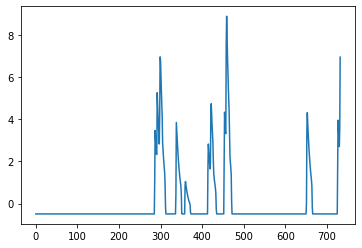

In [61]:
vigor_regressor = final_left_reg+final_right_reg
plt.plot(vigor_regressor)

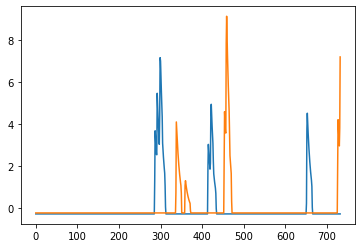

In [62]:
plt.plot(final_left_reg)
plt.plot(final_right_reg)

In [63]:
# trying to do cmap with pixel traces, and not the DF/F

# loading the tif image
im = Image.open('/home/mathilde.lapoix/Documents/RSN_project/Data/2P/' + fishlabel + '/' + plane + '/registered_stack_plane' + plane + '.tif')

# converting the tiff image in array
imarray = np.array(im)
nFrames = 846
# the tiff array will be in 3D: 2D of number of pixels, and the third D is the time.
tiff_array = np.zeros((imarray.shape[0], imarray.shape[1], nFrames))

In [64]:
# get each frame of the tif file to be concatenated to the array
for i, frame in enumerate(ImageSequence.Iterator(im)):
    tiff_array[:,:,i] = frame
    
# remove frames with movement
# frames_mov = np.where(np.isnan(F_corrected[0]))[0]
# tiff_array[:,:, frames_mov] = np.nan

# calculate the zscore of each trace, and reshape the array to lines as pixel number, and cols as time
pixel_traces = zscore(tiff_array.reshape((-1, tiff_array.shape[2])))

In [65]:
pixels = range(pixel_traces.shape[0])
cmap_left_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_left_reg,))
cmap_right_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_right_reg,))
# cmap_vigor_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_all_reg,))

In [66]:
cmap_vigor_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(vigor_regressor,))

In [67]:
# reshape from long format to height x width format
cmap_lp = np.array(cmap_left_pixel).reshape(*tiff_array.shape[0:2])
cmap_rp = np.array(cmap_right_pixel).reshape(*tiff_array.shape[0:2])
cmap_vp = np.array(cmap_vigor_pixel).reshape(*tiff_array.shape[0:2])

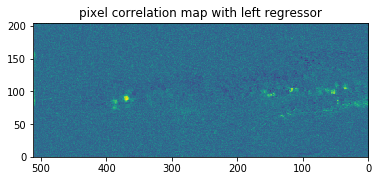

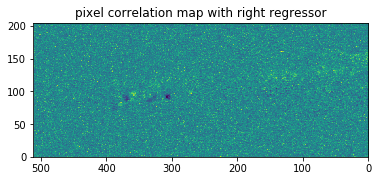

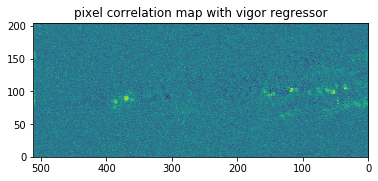

In [68]:
# quick view
plt.imshow(cmap_lp)
plt.title('pixel correlation map with left regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/pixel_cmap_left_reg.png')
plt.figure()
plt.imshow(cmap_rp)
plt.title('pixel correlation map with right regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/pixel_cmap_right_reg.png')
plt.figure()
plt.imshow(cmap_vp)
plt.title('pixel correlation map with vigor regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/pixel_cmap_vigor_reg.png')
